# ReadtheDocs Retrieval Augmented Generation (RAG)

In this notebook, we are going to use Milvus documentation pages to create a chatbot about our product.  The chatbot is going to follow RAG steps to retrieve chunks of data using Semantic Vector Search, then the Question + Context will be fed as a Prompt to a LLM to generate an answer.

Many RAG demos use OpenAI for the Embedding Model and ChatGPT for the Generative AI model.  **In this notebook, we will demo a fully open source RAG stack.**

Using open-source Q&A with retrieval saves money since we make free calls to our own data almost all the time - retrieval, evaluation, and development iterations.

<div>
<img src="../../../images/rag_image.png" width="80%"/>
</div>

Let's get started!

In [1]:
# For colab install these libraries in this order:
# !python -m pip install torch transformers sentence-transformers langchain
# !python -m pip install -U pymilvus
# !python -m pip install unstructured openai tqdm numpy ipykernel

In [2]:
# Import common libraries.
import sys, os, time, pprint
import numpy as np

# Import custom functions for splitting and search.
sys.path.append("../..")  # Adds higher directory to python modules path.
import milvus_utilities as _utils

In [3]:
# Function to remove newlines and double spaces from a string.
def clean_text(text):
    clean_text = text.replace("\n\n", " ")\
                     .replace("\n", " ")\
                     .replace("<br><br>", " ")\
                     .replace("<br /><br />", " ")
    
    # Remove extra whitespace.
    clean_text = ' '.join(clean_text.split())
    return clean_text

import numpy as np
import matplotlib.pyplot as plt

# Function to inspect chunk lengths in matplotlit.
def plot_chunk_lengths(chunked_docs, title_keyword):
    # Get chunk lengths.
    lengths = [len(doc.page_content) for doc in chunked_docs]

    # Mean, median lengths.
    mean_length = np.mean(lengths)
    median_length = np.median(lengths)

    # Assemble the title.
    title = f"Chunk Lengths from {title_keyword} Chunking"

    # Plot the lengths.
    plt.figure(figsize=(10, 6))  # Adjust figure size
    plt.plot(lengths, marker='o')  # Plot lengths with circle markers
    plt.title(title, fontsize=20, fontweight='bold')
    plt.xlabel('Document Index')  # X-axis label
    plt.ylabel('Length')  # Y-axis label
    plt.grid(True)  # Show grid

    # Add a horizontal line at mean and median length
    plt.axhline(y=mean_length, color='g', linestyle='-')
    plt.axhline(y=median_length, color='r', linestyle='-')
    plt.text(len(lengths)-1, mean_length, f'mean = {mean_length:.0f}', va='center', ha='left', backgroundcolor='w', fontsize=12)
    plt.text(0, median_length, f'median = {median_length:.0f}', va='center', ha='right', backgroundcolor='w', fontsize=12)

    plt.show()  # Display the plot

## Download Data

The data used in this notebook is Milvus documentation web pages.

The code block below downloads all the web pages into a local directory called `rtdocs`.  

I've already uploaded the `rtdocs` data folder to github, so you should see it if you cloned my repo.

In [4]:
# # UNCOMMENT TO DOWNLOAD THE DOCS.

# # !pip install -U langchain
# from langchain_community.document_loaders import RecursiveUrlLoader

# DOCS_PAGE="https://milvus.io/docs/"

# loader = RecursiveUrlLoader(DOCS_PAGE)
# docs = loader.load()

# num_documents = len(docs)
# print(f"loaded {num_documents} documents")

# # Print the type of the docs.
# print(type(docs))
# print(type(docs[0]))
# docs[0].page_content[:500]


# # UNCOMMENT TO SAVE THE DOCS LOCALLY.
# OUTPUT_DIR = "../../RAG/rtdocs_new/"
# os.makedirs(OUTPUT_DIR, exist_ok=True)

In [5]:
# From raw docs

# UNCOMMENT TO READ THE DOCS FROM A LOCAL DIRECTORY.

# Read docs into LangChain
# !pip install -U langchain
# !pip install unstructured
from langchain.document_loaders import DirectoryLoader

# Load HTML files already saved in a local directory.
path = "../../RAG/rtdocs_new/"
global_pattern = '*.html'
loader = DirectoryLoader(path=path, glob=global_pattern)
docs = loader.load()

num_documents = len(docs)
print(f"loaded {num_documents} documents")

# Clean up \n literals and source metdata.
for doc in docs:
    doc.page_content = clean_text(doc.page_content)
    doc.metadata["source"] = \
        doc.metadata["source"]\
            .replace("../../RAG/rtdocs_new", "https://milvus.io/docs")\
            .replace(".html", ".md")
    
print(docs[0].page_content[:500])
pprint.pprint(docs[0].metadata)

loaded 22 documents
Why Milvus Docs Tutorials Tools Blog Community Stars0 Try Managed Milvus FREE Search Home v2.4.x About Milvus Get StartedPrerequisitesInstall MilvusInstall SDKsQuickstart Concepts User Guide Models Administration Guide Tools Integrations Example Applications FAQs API reference Quickstart This guide explains how to connect to your Milvus cluster and performs CRUD operations in minutes Before you start You have installed Milvus standalone or Milvus cluster. You have installed preferred SDKs. You c
{'source': 'https://milvus.io/docs/quickstart.md'}


## Load the Embedding Model checkpoint and use it to create vector embeddings

#### What are Embeddings?

Check out [this blog](https://zilliz.com/glossary/vector-embeddings) for an introduction to embeddings.  

An excellent place to start is by selecting an embedding model from the [HuggingFace MTEB Leaderboard](https://huggingface.co/spaces/mteb/leaderboard), sorted descending by the "Retrieval Average'' column since this task is most relevant to RAG. Then, choose the smallest, highest-ranking embedding model. But, Beware!! some models listed are overfit to the training data, so they won't perform on your data as promised.  

Milvus (and Zilliz) only supports tested embedding models that are **not overfit**!

### Use open source Embedding Model from HuggingFace

In [6]:
import torch
from sentence_transformers import SentenceTransformer

# Initialize torch settings for device-agnostic code
N_GPU = torch.cuda.device_count()
DEVICE = torch.device('cuda:N_GPU' if torch.cuda.is_available() else 'cpu')

# Download the model from huggingface model hub.
model_name = "BAAI/bge-large-en-v1.5"
encoder = SentenceTransformer(model_name, device=DEVICE)
# print(encoder)

# Get the model parameters and save for later.
EMBEDDING_DIM = encoder.get_sentence_embedding_dimension()
MAX_SEQ_LENGTH_IN_TOKENS = encoder.get_max_seq_length() 
# # Assume tokens are 3 characters long.
# MAX_SEQ_LENGTH = MAX_SEQ_LENGTH_IN_TOKENS * 3
# HF_EOS_TOKEN_LENGTH = 1 * 3
# Test with 512 sequence length.
MAX_SEQ_LENGTH = MAX_SEQ_LENGTH_IN_TOKENS
HF_EOS_TOKEN_LENGTH = 1

# Inspect model parameters.
print(f"model_name: {model_name}")
print(f"EMBEDDING_DIM: {EMBEDDING_DIM}")
print(f"MAX_SEQ_LENGTH: {MAX_SEQ_LENGTH}")

/opt/miniconda3/envs/py311-unum/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model_name: BAAI/bge-large-en-v1.5
EMBEDDING_DIM: 1024
MAX_SEQ_LENGTH: 512


## Create Milvus Collection and Index

In [7]:
# Connect a client to the Milvus Lite server.
from pymilvus import MilvusClient
mc = MilvusClient("milvus_demo.db")

In [8]:
# Create vectorstore for vector index and retrieval.
COLLECTION_NAME = "MilvusDocs"

COLLECTION_NAME = "MilvusDocs"

# Milvus Lite uses the MilvusClient object.
if mc.has_collection(COLLECTION_NAME):
    mc.drop_collection(COLLECTION_NAME)
    print(f"Successfully dropped collection: `{COLLECTION_NAME}`")

# Create a collection with flexible schema and AUTOINDEX.
mc.create_collection(COLLECTION_NAME, 
        EMBEDDING_DIM,
        consistency_level="Eventually", 
        auto_id=True,  
        overwrite=True,
    )
print(f"Successfully created collection: `{COLLECTION_NAME}`")

Successfully dropped collection: `MilvusDocs`
Successfully created collection: `MilvusDocs`


## Fixed-length Chunking using LangChain

Before embedding, it is necessary to decide your chunk strategy, chunk size, and chunk overlap.  This section uses:
- **Strategy** = Use markdown header hierarchies.  Keep markdown sections together unless they are too long.
- **Chunk size** = Use the embedding model's parameter `MAX_SEQ_LENGTH`
- **Overlap** = Rule-of-thumb 10-15%
- **Function** = 
  - Langchain's `RecursiveCharacterTextSplitter` to split up long reviews recursively.

Notice below, each chunk is grounded with the document source page.  <br>

chunk_size: 512, chunk_overlap: 51.0
22 docs split into 355 child documents.


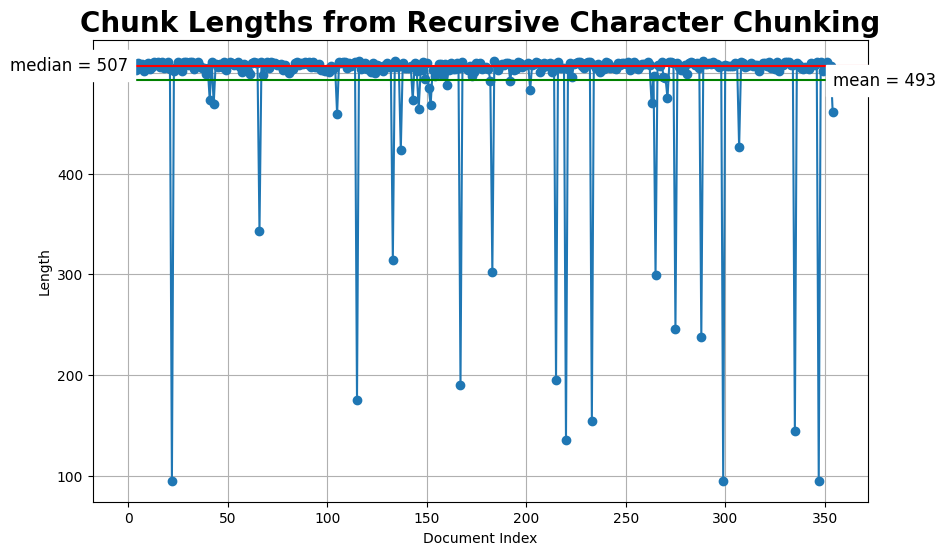

In [9]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

CHUNK_SIZE = 512
chunk_overlap = np.round(CHUNK_SIZE * 0.10, 0)
print(f"chunk_size: {CHUNK_SIZE}, chunk_overlap: {chunk_overlap}")

# The splitter to create smaller (child) chunks
# Default splitters: https://github.com/langchain-ai/langchain/blob/9ef2feb6747f5a69d186bd623b569ad722829a5e/libs/langchain/langchain/text_splitter.py#L842
child_splitter = RecursiveCharacterTextSplitter(
    chunk_size=CHUNK_SIZE, 
    chunk_overlap=chunk_overlap,
    # length_function = len,  # use built-in Python len function
    # separators = ["\n\n", "\n", " ", ". ", ""], # these are defaults
)

# Child docs for inspection
chunks = child_splitter.split_documents(docs)
print(f"{len(docs)} docs split into {len(chunks)} child documents.")

# Inspect chunk lengths
plot_chunk_lengths(chunks, 'Recursive Character')

## Transform Chunks into Vectors

In [10]:
# Encoder input is doc.page_content as strings.
list_of_strings = [doc.page_content for doc in chunks if hasattr(doc, 'page_content')]

# Embedding inference using HuggingFace encoder.
start_time = time.time()
embeddings = torch.tensor(encoder.encode(list_of_strings))
end_time = time.time()

print(f"Embedding time for {len(list_of_strings)} chunks: ", end="")
print(f"{round(end_time - start_time, 2)} seconds")

Embedding time for 355 chunks: 34.82 seconds


In [11]:
# Normalize the embeddings.
embeddings = np.array(embeddings / np.linalg.norm(embeddings))

# Milvus expects a list of `numpy.ndarray` of `numpy.float32` numbers.
converted_values = list(map(np.float32, embeddings))

# Inspect the embeddings.
assert len(chunks[0].page_content) <= MAX_SEQ_LENGTH-1
assert len(converted_values[0]) == EMBEDDING_DIM
print(f"type embeddings: {type(converted_values)} of {type(converted_values[0])}")
print(f"of numbers: {type(converted_values[0][0])}")

type embeddings: <class 'list'> of <class 'numpy.ndarray'>
of numbers: <class 'numpy.float32'>


## Insert data into Milvus

For each original text chunk, we'll write the sextuplet (`chunk, h1, h2, source, dense_vector, sparse_vector`) into the database.

<div>
<img src="../../../images/db_insert.png" width="80%"/>
</div>

**The Milvus Client wrapper can only handle loading data from a list of dictionaries.**

Otherwise, in general, Milvus supports loading data from:
- pandas dataframes 
- list of dictionaries

Below, we use the embedding model provided by HuggingFace, download its checkpoint, and run it locally as the encoder.

In [12]:
# Create dict_list for Milvus insertion.
dict_list = []
for chunk, vector in zip(chunks, converted_values):
    # Assemble embedding vector, original text chunk, metadata.
    chunk_dict = {
        'chunk': chunk.page_content,
        'source': chunk.metadata.get('source', ""),
        'vector': vector,
    }
    dict_list.append(chunk_dict)

# # TODO - Uncomment to inspect the first chunk and its metadata.
# print(len(dict_list))
# print(type(dict_list[0]), len(dict_list[0]))
# pprint.pprint(dict_list[0])

# Insert data into the Milvus collection.
print("Start inserting entities")
start_time = time.time()
mc.insert(
    COLLECTION_NAME,
    data=dict_list,
    progress_bar=True)

end_time = time.time()
print(f"Milvus insert time for {len(dict_list)} vectors: ", end="")
print(f"{round(end_time - start_time, 2)} seconds")

Start inserting entities
Milvus insert time for 355 vectors: 0.21 seconds


## Define 4 questions

Search Milvus using [PyMilvus API](https://milvus.io/docs/search.md).

💡 By their nature, vector searches are "semantic" searches.  For example, if you were to search for "leaky faucet": 
> **Traditional Key-word Search** - either or both words "leaky", "faucet" would have to match some text in order to return a web page or link text to the document.

> **Semantic search** - results containing words "drippy" "taps" would be returned as well because these words mean the same thing even though they are different words.


In [13]:
# Define a sample question about your data.
QUESTION1 = "What do the parameters for HNSW mean?"
QUESTION2 = "What are good default values for HNSW parameters with 25K vectors dim 1024?"
QUESTION3 = "What does nlist vs nprobe mean in ivf_flat?"
QUESTION4 = "What is the default AUTOINDEX index and vector field distance metric in Milvus?"

# In case you want to ask all the questions at once.
QUERY = [QUESTION1, QUESTION2, QUESTION3, QUESTION4]

# Inspect the length of one question.
QUERY_LENGTH = len(QUESTION2)
print(f"example query length: {QUERY_LENGTH}")

example query length: 75


In [14]:
SAMPLE_QUESTION = QUESTION1

## Execute a vector search

Search Milvus using [PyMilvus API](https://milvus.io/docs/search.md).

💡 By their nature, vector searches are "semantic" searches.  For example, if you were to search for "leaky faucet": 
> **Traditional Key-word Search** - either or both words "leaky", "faucet" would have to match some text in order to return a web page or link text to the document.

> **Semantic search** - results containing words "drippy" "taps" would be returned as well because these words mean the same thing even though they are different words.

In [15]:
# Define metadata fields you can filter on.
OUTPUT_FIELDS = list(dict_list[0].keys())
OUTPUT_FIELDS.remove('vector')
print(f"output fields: {OUTPUT_FIELDS}")

# Define how many top-k results you want to retrieve.
TOP_K = 2

# Define a convenience function for searching.
def mc_run_search(question, filter_expression, top_k=2):
    # Embed the question using the same encoder.
    query_embeddings = _utils.embed_query(encoder, [question])

    # Run semantic vector search using your query and the vector database.
    results = mc.search(
        COLLECTION_NAME,
        data=query_embeddings,
        output_fields=OUTPUT_FIELDS, 
        # Milvus can utilize metadata in boolean expressions to filter search.
        filter=filter_expression,
        limit=top_k,
        consistency_level="Eventually"
    )

    # Assemble retrieved context and context metadata.
    # The search result is in the variable `results[0]`, which is type 
    # 'pymilvus.orm.search.SearchResult'. 
    METADATA_FIELDS = [f for f in OUTPUT_FIELDS if f != 'chunk']
    formatted_results, context, context_metadata = _utils.client_assemble_retrieved_context(
        results, metadata_fields=METADATA_FIELDS, num_shot_answers=top_k)
    
    return formatted_results, context, context_metadata

output fields: ['chunk', 'source']


In [16]:
# RETRIEVE ANSWERS FROM YOUR DOCUMENTS STORED IN MILVUS OR ZILLIZ.

# Metadata filters for CSV dataset.
# expression = 'film_year >= 2019'
expression = ""
print(f"filter: {expression}")

start_time = time.time()
formatted_results, contexts, context_metadata = \
    mc_run_search(SAMPLE_QUESTION, expression)
elapsed_time = time.time() - start_time
print(f"Milvus Client search time for {len(dict_list)} vectors: {elapsed_time} seconds")

# Inspect search result.
print(f"type: {type(formatted_results)}, count: {len(formatted_results)}")

filter: 
Milvus Client search time for 355 vectors: 0.17427706718444824 seconds
type: <class 'list'>, count: 2


In [17]:
# Loop through search results, print metadata.
sources = []
for i in range(len(contexts)):
    print(f"Retrieved result #{i+1}")
    print(f"distance = {formatted_results[i][0]}")
    pprint.pprint(f"Chunk text: {contexts[i]}")
    for key, value in context_metadata[i].items():
        if key == "source":
            sources.append(value)
        print(f"{key}: {value}")
    print()

Retrieved result #1
distance = 0.7001987099647522
('Chunk text: layer, finds the node closest to the target in this layer, and '
 'then enters the next layer to begin another search. After multiple '
 'iterations, it can quickly approach the target position. In order to improve '
 'performance, HNSW limits the maximum degree of nodes on each layer of the '
 'graph to M. In addition, you can use efConstruction (when building index) or '
 'ef (when searching targets) to specify a search range. Index building '
 'parameters Parameter Description Range M M defines tha maximum number of '
 'outgoing')
source: https://milvus.io/docs/index.md

Retrieved result #2
distance = 0.6953287124633789
('Chunk text: this value can improve recall rate at the cost of increased '
 'search time. [1, 65535] 2 HNSW HNSW (Hierarchical Navigable Small World '
 'Graph) is a graph-based indexing algorithm. It builds a multi-layer '
 'navigation structure for an image according to certain rules. In this '
 'struc

## Get ready for G-Generation part of RAG

In [18]:
# Define temperature for the LLM and random seed.
TEMPERATURE = 0.1
TOP_P = 0.9
RANDOM_SEED = 415
MAX_TOKENS = 512
FREQUENCY_PENALTY = 2

In [19]:
# Separate all the context together by space.
contexts_combined = ' '.join(contexts)
# Lance Martin, LangChain, says put the best contexts at the end.
contexts_combined = ' '.join(reversed(contexts))

print(f"Length long text to summarize: {len(contexts_combined)}")

# Separate all the unique sources together by comma.
source_combined = ' '.join(reversed(list(dict.fromkeys(sources))))
print(f"sources: {source_combined}")

Length long text to summarize: 1021
sources: https://milvus.io/docs/index.md


# Use an LLM to Generate a chat response to the user's question using the Retrieved Context.

Many different generative LLMs exist these days.  Check out the lmsys [leaderboard](https://chat.lmsys.org/?leaderboard).

In this notebook, we'll try these LLMs:
- The newly released open-source Llama 3 from Meta.
- The cheapest, paid model from Anthropic Claude3 Haiku.
- The standard in its price cateogory, gpt-3.5-turbo, from Openai.

In [20]:
SYSTEM_PROMPT = f"""First, check if the provided Context is relevant to 
the user's question.  Second, only if the provided Context is strongly relevant, 
answer the question using the Context.  Otherwise, if the Context is not 
strongly relevant, answer the question without using the Context.  
Be clear, concise, relevant.  Answer clearly, in fewer than 2 sentences.
Grounding sources: {source_combined}
Context: {contexts_combined}
"""
print(f"Length prompt: {len(SYSTEM_PROMPT)}")

# Inspect the prompt.
# pprint.pprint(SYSTEM_PROMPT)

Length prompt: 1432


### Try Meta Llama 3 with Ollama to generate a human-like chat response to the user's question

Follow the instructions to install ollama and pull a model.<br>
https://github.com/ollama/ollama

View details about which models are supported by ollama. <br>
https://ollama.com/library/llama3

That page says `ollama run llama3` will by default pull the latest "instruct" model, which is fine-tuned for chat/dialogue use cases.

The other kind of llama3 models are "pre-trained" base model. <br>
Example: ollama run llama3:text ollama run llama3:70b-text

**Format** `gguf` means the model runs on CPU.  gg = "Georgi Gerganov", creator of the C library model format ggml, which was recently changed to gguf.

**Quantization** (think of it like vector compaction) can lead to higher throughput at the expense of lower accuracy.  For the curious, quantization meanings can be found on: <br>
https://huggingface.co/TheBloke/Llama-2-13B-chat-GGML/tree/main.  

Below just listing the main quantization types.
- **q4_0**: Original quant method, 4-bit.
- **q4_k_m**: Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q4_K
- **q5_0**: Higher accuracy, higher resource usage and slower inference.
- **q5_k_m**: Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q5_K
- **q 6_k**: Uses Q8_K for all tensors
- **q8_0**: Almost indistinguishable from float16. High resource use and slow. Not recommended for most users.

In [21]:
# !python -m pip install ollama
# !ollama pull llama3.1
import ollama

# Verify details which model you are running.
# ollama.list()['models'][0]

# Print the model details.
keys = ['format', 'parameter_size', 'quantization_level']
print(f"MODEL:{ollama.list()['models'][0]['name']}", end=", ")
for key in keys:
    print(f"{str.upper(key)}:{ollama.list()['models'][0]['details'].get(key, 'Key not found in dictionary')}", end=", ")
print(end="\n\n")

MODEL:llama3.1:latest, FORMAT:gguf, PARAMETER_SIZE:8.0B, QUANTIZATION_LEVEL:Q4_0, 



In [22]:
# Send the question to llama 3 chat.
start_time = time.time()
response = ollama.chat(
    messages=[
        {"role": "system", "content": SYSTEM_PROMPT,},
        
        {"role": "user", "content": f"question: {SAMPLE_QUESTION}",}
    ],
    model='llama3',
    stream=False,
    options={"temperature": TEMPERATURE, "seed": RANDOM_SEED,
             "top_p": TOP_P, 
            #  "max_tokens": MAX_TOKENS,
             "frequency_penalty": FREQUENCY_PENALTY}
)

ollama_llama3_time = time.time() - start_time
pprint.pprint(response['message']['content'])
print(f"ollama_llama3_time: {format(ollama_llama3_time, '.2f')} seconds")

('The parameter "M" in HNSW limits the maximum degree of nodes on each layer, '
 'controlling recall rate and search time. A higher value can improve recall '
 'at a cost of increased search time.')
ollama_llama3_time: 10.65 seconds


In [23]:
# Also try OctoAI
# !python -m pip install octoai
# Models supported: https://octo.ai/models/
from octoai.text_gen import ChatMessage
from octoai.client import OctoAI

# LLM_NAME = "meta-llama-3-8b-instruct"
LLM_NAME = "meta-llama/meta-llama-3.1-8b-instruct"

octoai_client = OctoAI(
    api_key=os.environ.get("OCTOAI_TOKEN"),
)

# Generate response using OpenAI API.
start_time = time.time()
response = octoai_client.text_gen.create_chat_completion(
	messages=[
		ChatMessage(
			content=SYSTEM_PROMPT,
			role="system"
		),
		ChatMessage(
			content=SAMPLE_QUESTION,
			role="user"
		)
	],
	model=LLM_NAME,
    temperature=TEMPERATURE,
    # seed=RANDOM_SEED,
    frequency_penalty=FREQUENCY_PENALTY,
    top_p=TOP_P, 
    max_tokens=MAX_TOKENS,
)
llama3_octai_endpoints_time = time.time() - start_time

# Print the response.
pprint.pprint(response.choices[0].message.content.replace('\n', ' '))
print(f"llama3_octai_endpoints_time: {format(llama3_octai_endpoints_time, '.2f')} seconds")

('The parameters for HNSW (Hierarchical Navigable Small World Graph) are:  * '
 'M: The maximum degree of nodes on each layer of the graph, which can improve '
 'recall rate at the cost of increased search time. * efConstruction and ef: '
 'These parameters specify a search range when building or searching an index.')
llama3_octai_endpoints_time: 1.72 seconds


In [24]:
# Also try Groq endpoints
# !python -m pip install groq
# Models supported: https://console.groq.com/docs/models
from groq import Groq

# LLM_NAME = "llama3-8b-8192"
LLM_NAME = "llama-3.1-8b-instant"

groq_client = Groq(
    api_key=os.environ.get("GROQ_API_KEY"),
)

# Generate response using OpenAI API.
start_time = time.time()
response = groq_client.chat.completions.create(
    messages=[
        {"role": "system", "content": SYSTEM_PROMPT,},
        {"role": "user", "content": f"question: {SAMPLE_QUESTION}",}
    ],
    model=LLM_NAME,
    temperature=TEMPERATURE,
    seed=RANDOM_SEED,
    frequency_penalty=FREQUENCY_PENALTY,
    top_p=TOP_P, 
    max_tokens=MAX_TOKENS,
)
llama3_groq_endpoints_time = time.time() - start_time

# Print the response.
pprint.pprint(response.choices[0].message.content.replace('\n', ' '))
print(f"llama3_groq_endpoints_time: {format(llama3_groq_endpoints_time, '.2f')} seconds")

('The parameters for HNSW (Hierarchical Navigable Small World Graph) are:  * '
 'M: Maximum degree of nodes on each layer of the graph, which can be adjusted '
 'to balance recall rate and search time. * efConstruction (or ef): Search '
 'range when building the index, which can be used to control the trade-off '
 'between recall rate and search time.')
llama3_groq_endpoints_time: 0.54 seconds


## Also try OpenAI

💡 Note: For use cases that need to always be factually grounded, use very low temperature values while more creative tasks can benefit from higher temperatures.

In [25]:
SYSTEM_PROMPT = f"""First, check if the provided Context is relevant to 
the user's question.  Second, only if the provided Context is strongly relevant, 
answer the question using the Context.  Otherwise, if the Context is not 
strongly relevant, answer the question without using the Context.
Be clear, concise, relevant.  Answer clearly, easy to understand, 
fewer than 2 sentences, and cite unique grounding sources.
Grounding sources: {source_combined}
Context: {contexts_combined}
"""
print(f"Length prompt: {len(SYSTEM_PROMPT)}")

# Inspect the prompt.
# pprint.pprint(SYSTEM_PROMPT)

Length prompt: 1483


In [26]:
import openai, pprint
from openai import OpenAI

# 1. Define the generation llm model to use.
# LLM_NAME = "gpt-3.5-turbo"
LLM_NAME = "gpt-4o-mini"

# 2. Get your API key: https://platform.openai.com/api-keys
# 3. Save your api key in env variable.
# https://help.openai.com/en/articles/5112595-best-practices-for-api-key-safety
openai_client = OpenAI(
    # This is the default and can be omitted
    api_key=os.environ.get("OPENAI_API_KEY"),
)

# 4. Generate response using the OpenAI API.
start_time = time.time()
response = openai_client.chat.completions.create(
    messages=[
        {"role": "system", "content": SYSTEM_PROMPT,},
        {"role": "user", "content": f"question: {SAMPLE_QUESTION}",}
    ],
    model=LLM_NAME,
    temperature=TEMPERATURE,
    seed=RANDOM_SEED,
    frequency_penalty=FREQUENCY_PENALTY,
)
chatgpt_35turbo_time = time.time() - start_time

# Print the question and answer along with grounding sources and citations.
print(f"Question: {SAMPLE_QUESTION}")

# 5. Print all answers in the response.
for i, choice in enumerate(response.choices, 1):
    pprint.pprint(f"Answer: {choice.message.content}")
    print("\n")
print(f"chatgpt_3.5_turbo_time: {format(chatgpt_35turbo_time, '.5f')}")

Question: What do the parameters for HNSW mean?
('Answer: The parameters for HNSW (Hierarchical Navigable Small World Graph) '
 'include M, which defines the maximum number of outgoing connections from '
 'each node in the graph, and efConstruction or ef, which specify the search '
 'range during index building and searching respectively. These parameters '
 'help control the trade-off between recall rate and search time.')


chatgpt_3.5_turbo_time: 1.57389


In [27]:
# # Drop the collection.
# mc.drop_collection(COLLECTION_NAME)
# print(f"Successfully dropped collection: `{COLLECTION_NAME}`")

In [28]:
# Props to Sebastian Raschka for this handy watermark.
# !pip install watermark
%load_ext watermark

%watermark -a 'Christy Bergman' -v -p unstructured,torch,pymilvus,langchain,ollama,groq,octoai,openai --conda

Author: Christy Bergman

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

unstructured: 0.14.4
torch       : 2.3.0
pymilvus    : 2.4.4
langchain   : 0.2.6
ollama      : 0.1.8
groq        : 0.8.0
octoai      : 1.0.2
openai      : 1.35.0

conda environment: py311-unum

